In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [16]:
dataTrain=pd.read_csv("allAtt_onehot_large_train_new8.csv")
dataTest=pd.read_csv("allAtt_onehot_large_test_new8.csv")
print(dataTrain.head(10))
print(dataTrain.shape)

         Date     HomeTeam    AwayTeam  FTR   VCH  B365H  HTGS  ATGS  HTGC  \
0  2010-08-14  Aston Villa    West Ham    0  2.00   2.00   0.0   0.0   0.0   
1  2010-08-14    Blackburn     Everton    0  3.10   2.88   0.0   0.0   0.0   
2  2010-08-14       Bolton      Fulham    1  2.20   2.20   0.0   0.0   0.0   
3  2010-08-14      Chelsea   West Brom    0  1.17   1.17   0.0   0.0   0.0   
4  2010-08-14   Sunderland  Birmingham    1  2.20   2.10   0.0   0.0   0.0   
5  2010-08-14    Tottenham    Man City    1  2.30   2.40   0.0   0.0   0.0   
6  2010-08-14        Wigan   Blackpool    1  1.83   1.83   0.0   0.0   0.0   
7  2010-08-14       Wolves       Stoke    0  2.30   2.30   0.0   0.0   0.0   
8  2010-08-15    Liverpool     Arsenal    1  2.50   2.50   0.0   0.0   0.0   
9  2010-08-16   Man United   Newcastle    0  1.22   1.25   0.0   0.0   0.0   

   ATGC  ...  DiffPts  DiffFormPts  DiffLP  H2HM1  H2HM2  H2HM3  H2HM4  H2HM5  \
0   0.0  ...      0.0          0.0   -11.0     -1     -1    

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1. 数据加载
x_train = dataTrain.iloc[:, 4:38].values
y_train = dataTrain.iloc[:, 38:].values  # 独热编码：如 [1,0] or [0,1]
x_test = dataTest.iloc[:, 4:38].values
y_test = dataTest.iloc[:, 38:].values

# 2. Reshape 给 LSTM 用（需要 3D 输入）
x_train_lstm = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_lstm = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# 3. 其他模型使用单标签形式
y_train_cls = np.argmax(y_train, axis=1)
y_test_cls = np.argmax(y_test, axis=1)


In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# 模型列表
models = {
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, kernel='rbf', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# 循环训练、预测与输出
for name, model in models.items():
    print(f'\n====== {name} ======')
    model.fit(x_train, y_train_cls)
    y_pred = model.predict(x_test)
    
    acc = accuracy_score(y_test_cls, y_pred)
    print(f'Accuracy: {acc:.4f}\n')
    
    print(classification_report(y_test_cls, y_pred, digits=4))



====== Naive Bayes ======
Accuracy: 0.6553

              precision    recall  f1-score   support

           0     0.5991    0.7600    0.6700       175
           1     0.7342    0.5659    0.6391       205

    accuracy                         0.6553       380
   macro avg     0.6666    0.6629    0.6546       380
weighted avg     0.6720    0.6553    0.6534       380


====== Decision Tree ======
Accuracy: 0.6132

              precision    recall  f1-score   support

           0     0.5778    0.5943    0.5859       175
           1     0.6450    0.6293    0.6370       205

    accuracy                         0.6132       380
   macro avg     0.6114    0.6118    0.6115       380
weighted avg     0.6140    0.6132    0.6135       380


====== SVM ======
Accuracy: 0.6816

              precision    recall  f1-score   support

           0     0.6709    0.6057    0.6366       175
           1     0.6892    0.7463    0.7166       205

    accuracy                         0.6816       380

In [18]:
## lstm
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 1).
# Each input sequence will be of size (28, 1).
input_dim = 34

units = 64
output_size = 2  # labels are from Win or Loss

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(input_dim,1))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(input_dim,1)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size, activation="softmax"),
        ]
    )
    return model


model_lstm = build_model(allow_cudnn_kernel=True)


model_lstm.compile(
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer="Adam",
    metrics=["categorical_accuracy"]
)

model_lstm.summary()


model_lstm.fit(
    x_train_lstm, y_train,
    validation_split=0.1,  # 可选，用于验证集
    epochs=20,
    batch_size=batch_size,
    # callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,282 (67.51 KB)

 Trainable params: 17,154 (67.01 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - categorical_accuracy: 0.5941 - loss: 0.6814 - val_categorical_accuracy: 0.5202 - val_loss: 0.6849
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.6392 - loss: 0.6325 - val_categorical_accuracy: 0.5344 - val_loss: 0.6852
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.6609 - loss: 0.6298 - val_categorical_accuracy: 0.5628 - val_loss: 0.6811
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - categorical_accuracy: 0.6481 - loss: 0.6278 - val_categorical_accuracy: 0.5931 - val_loss: 0.6817
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.6461 - loss: 0.6259 - val_categorical_accuracy: 0.5850 - val_loss: 0.6774
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.6592 - loss: 0.6234 - val_categorical_accuracy: 0.5445 - val_loss: 0.6919
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - categorical_accuracy: 0.6485 - loss: 0.6

In [20]:
# 使用 XGBoost 训练
import xgboost as xgb
model_xgb = xgb.XGBClassifier(
    objective="multi:softmax",  # 指定为多分类问题
    num_class=2,  # 三个类别
    eval_metric="mlogloss",  # 计算多类对数损失
    use_label_encoder=False,  # 防止警告
)

# 训练模型
model_xgb.fit(x_train, y_train_cls)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=2, ...)

In [22]:
import lightgbm as lgb
# 创建 LightGBM
model_lgb = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=2,
    metric='multi_logloss',
    random_state=42
)

# 模型训练
model_lgb.fit(x_train, y_train_cls)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2193
[LightGBM] [Info] Number of data points in the train set: 4940, number of used features: 34
[LightGBM] [Info] Start training from score -0.792230
[LightGBM] [Info] Start training from score -0.603003


LGBMClassifier(metric='multi_logloss', num_class=2, objective='multiclass',
               random_state=42)

In [23]:
# 构建 CatBoostClassifier
model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=0,  # 训练过程不打印输出
    random_seed=42
)

# 训练模型
model_cat.fit(x_train, y_train_cls)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


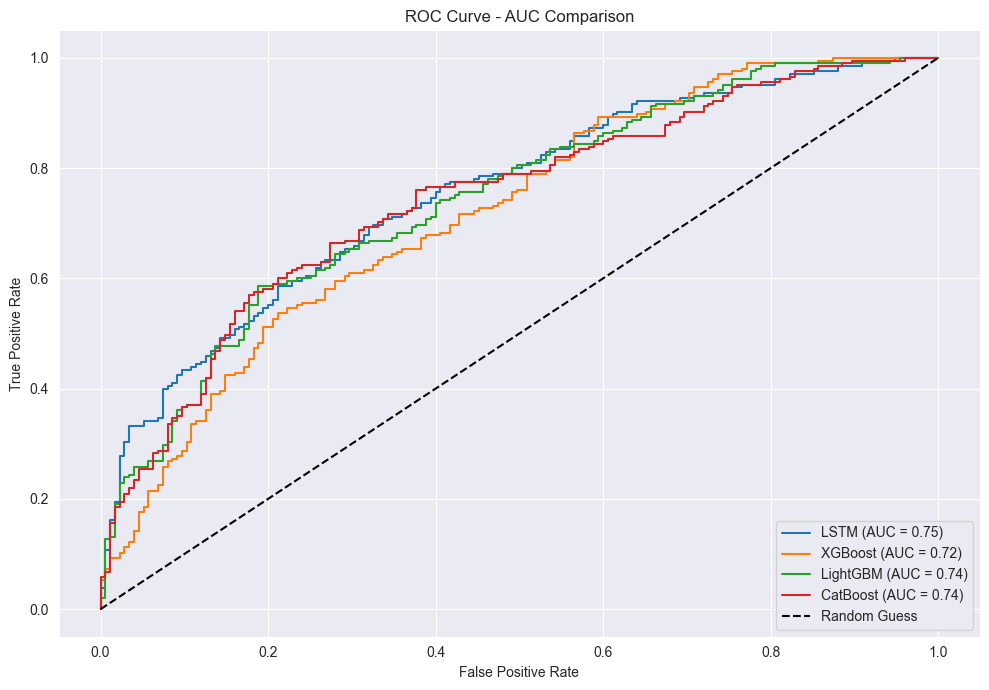

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# # 模型预测
# y_pred = model_lstm.predict(x_test_lstm)
# 
# # 真实标签转换为单一标签（从 one-hot 变成整数）
# y_true = np.argmax(y_test, axis=1)
# y_scores = y_pred[:, 1]  # 取类别1的概率
# 
# # 计算ROC曲线
# fpr, tpr, _ = roc_curve(y_true, y_scores)
# roc_auc = auc(fpr, tpr)


# 将 one-hot 标签还原为单标签
y_test_cls = np.argmax(y_test, axis=1)

# 预测概率值
y_pred_lstm = model_lstm.predict(x_test_lstm)[:,1]
y_pred_xgb = model_xgb.predict_proba(x_test)[:, 1]
y_pred_lgb = model_lgb.predict_proba(x_test)[:, 1]
y_pred_cat = model_cat.predict_proba(x_test)[:, 1]

# 计算 ROC 曲线和 AUC 值
fpr_lstm, tpr_lstm, _ = roc_curve(y_test_cls, y_pred_lstm)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_cls, y_pred_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test_cls, y_pred_lgb)
fpr_cat, tpr_cat, _ = roc_curve(y_test_cls, y_pred_cat)

auc_lstm = roc_auc_score(y_test_cls, y_pred_lstm)
auc_xgb = roc_auc_score(y_test_cls, y_pred_xgb)
auc_lgb = roc_auc_score(y_test_cls, y_pred_lgb)
auc_cat = roc_auc_score(y_test_cls, y_pred_cat)

# 绘图
plt.figure(figsize=(10, 7))
plt.plot(fpr_lstm, tpr_lstm, label=f"LSTM (AUC = {auc_lstm:.2f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.2f})")
plt.plot(fpr_lgb, tpr_lgb, label=f"LightGBM (AUC = {auc_lgb:.2f})")
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC = {auc_cat:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - AUC Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()